# From YAML to nodes and operators in a network
This is a short overview on how to get from a template defined in YAML to an intermediate representation in PyRates that includes
- Operators with equations and variable type specifications
- Nodes with references to operators and variable values
- Edges with operator references and source/target node/variable information

and can be parsed to deploy on tensorflow or something else.

In [1]:
# navigate to pyrates directory, since loading of YAML templates with module initialisation is not implemented yet

In [2]:
cd /home/raid1/drose/PhD/12_NMM_Framework/PyRates/

/home/raid1/drose/PhD/12_NMM_Framework/PyRates


## For reference: A simple template in YAML 1.2
The below code prints a .yaml text file, defining a very basic operator. The YAML-file serves as both definition and documentation of a template. 

In [3]:
from ruamel.yaml import YAML
# initialize YAML parser
yaml = YAML(typ="safe", pure=True) 
# "safe" disallows parsing of comments, 
# pure ensures we can use YAML 1.2
with open("pyrates/axon/axon.yaml", "r") as file:
    for line in file:
        print(line)

%YAML 1.2

---

PotentialToRateOperator:

  base: OperatorTemplate

  equation: "L_PRO * m_out = r * V"

  variables:

    L_PRO:

      description: Generic linear differential operator

      unit: null

      default: 1

    m_out:

      name: outgoing_firing_rate

      description: Mean outgoing firing rate at axonal hillock

      unit: 1/s

      default: output

    r:

      description: Generic scaling constant that transforms voltage to firing rate.

      unit: 1/(s*V)

      default: 1

    V:

      name: membrane_potential

      description: Mean somatic membrane potential

      unit: V

      default: input

  description: "Generic potential-to-rate operator (PRO) to be replaced

    with a meaningful function. The PRO encodes the transformation of

    mean somatic membrane potential to an outgoing firing rate at the

    axonal hillocks of a neural population."


__The above file is parsed as a python dictionary as follows:__

In [4]:
with open("pyrates/axon/axon.yaml", "r") as file:
    parsed = yaml.load(file)
parsed

{'PotentialToRateOperator': {'base': 'OperatorTemplate',
  'equation': 'L_PRO * m_out = r * V',
  'variables': {'L_PRO': {'description': 'Generic linear differential operator',
    'unit': None,
    'default': 1},
   'm_out': {'name': 'outgoing_firing_rate',
    'description': 'Mean outgoing firing rate at axonal hillock',
    'unit': '1/s',
    'default': 'output'},
   'r': {'description': 'Generic scaling constant that transforms voltage to firing rate.',
    'unit': '1/(s*V)',
    'default': 1},
   'V': {'name': 'membrane_potential',
    'description': 'Mean somatic membrane potential',
    'unit': 'V',
    'default': 'input'}},
  'description': 'Generic potential-to-rate operator (PRO) to be replaced with a meaningful function. The PRO encodes the transformation of mean somatic membrane potential to an outgoing firing rate at the axonal hillocks of a neural population.'}}

__Note__: Sub-templates can replace some parts or everything in their parent

### Dynamic loading of YAML-templates into python classes
Three elementary template classes are implemented in python:
- OperatorTemplate: definitions of equations and their variables
- NodeTemplate: a network node that summarises multiple operators
- CircuitTemplate: an entire network with nodes and edges

The method `.from_yaml` is a shorthand to the respective loaders

In [5]:
from pyrates.operator.operator import OperatorTemplate

/nobackup/jamaika1/drose/anaconda3/envs/nmm/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:
path = "pyrates.axon.templates.SigmoidPRO"

In [7]:
template = OperatorTemplate.from_yaml(path)
template

<OperatorTemplate 'pyrates.axon.templates.SigmoidPRO'>

In [8]:
template.equation

'm_out = m_max / (1 + exp(s*(V_thr - V)))'

In [9]:
template.variables

{'m_out': {'name': 'outgoing_firing_rate',
  'description': 'Mean outgoing firing rate at axonal hillock',
  'unit': '1/s',
  'default': 'output'},
 'r': {'description': 'Generic scaling constant that transforms voltage to firing rate.',
  'unit': '1/(s*V)',
  'default': 1},
 'V': {'name': 'membrane_potential',
  'description': 'Mean somatic membrane potential',
  'unit': 'V',
  'default': 'input'},
 'm_max': {'name': 'max_firing_rate',
  'description': 'Determines maximum firing rate of axon.',
  'unit': '1/s',
  'default': 'constant(float)',
  'allowed_range': '>= 0'},
 's': {'name': 'slope',
  'description': 'Determines slope of the sigmoidal transfer function at the firing threshold.',
  'default': 'constant(float)'},
 'V_thr': {'name': 'firing_threshold',
  'description': 'Determines membrane potential for which output firing rate is half the maximum firing rate.',
  'default': 'constant(float)',
  'unit': 'V'}}

__Note:__ The same can be achieved by passing the necessary data to the template class in python

In [10]:
template2 = OperatorTemplate(template.name, template.path, template.equation, 
                             template.variables, template.__doc__, template.options)

In [11]:
template2.__dict__ == template.__dict__

True

### Loading a circuit template
A circuit templates contains references to templates of nodes, edges and coupling operators

In [12]:
from pyrates.circuit import CircuitTemplate

In [13]:
circuit_template = CircuitTemplate.from_yaml("pyrates.circuit.templates.JansenRitCircuit")

In [14]:
# note that JR_IIN and JR_EIN refer to the same template
circuit_template.nodes

{'JR_PC': <NodeTemplate 'pyrates.population.templates.JansenRitPC'>,
 'JR_IIN': <NodeTemplate 'pyrates.population.templates.JansenRitIN'>,
 'JR_EIN': <NodeTemplate 'pyrates.population.templates.JansenRitIN'>}

In [15]:
circuit_template.edges

[['JR_PC', 'JR_IIN', 'LC', {'c': 33.75}],
 ['JR_PC', 'JR_EIN', 'LC', {'c': 135}],
 ['JR_EIN', 'JR_PC', 'LC', {'c': 108}],
 ['JR_IIN', 'JR_PC', 'LC', {'c': 33.75}]]

In [16]:
circuit_template.coupling

{'LC': <OperatorTemplate 'pyrates.coupling.templates.LinearCoupling'>}

### Instantiating a circuit
A circuit instance is a networkx.MultiDiGraph, but overwrites parts of the methods. 

In [24]:
circuit = circuit_template.apply()
circuit

In [25]:
circuit.nodes

NodeView(('JR_PC', 'JR_IIN', 'JR_EIN'))

In [43]:
circuit.edges

OutMultiEdgeView([('JR_PC', 'JR_IIN', 0), ('JR_PC', 'JR_EIN', 0), ('JR_IIN', 'JR_PC', 0), ('JR_EIN', 'JR_PC', 0)])

In [64]:
# reference to coupling opeator
circuit.edges[("JR_PC", "JR_IIN", 0)]["coupling"]

{'equation': 'm_in = c * m_out',
 'variables': {'m_in': {'name': 'incoming_firing_rate',
   'description': 'Mean incoming firing rate at pre-synaptic terminal',
   'unit': '1/s',
   'variable_type': 'state_variable',
   'data_type': 'float32'},
  'c': {'name': 'connection_strength',
   'description': 'Connectivity constant that reflects connection strength from one neural population on another.',
   'unit': None,
   'variable_type': 'constant',
   'data_type': 'int32'},
  'm_out': {'name': 'outgoing_firing_rate',
   'description': 'Mean outgoing firing rate at axonal hillock of pre-synaptic neuron.',
   'unit': '1/s',
   'variable_type': 'state_variable',
   'data_type': 'float32'}}}

In [65]:
# reference to connection-specific values
circuit.edges[("JR_PC", "JR_IIN", 0)]["values"]

{'c': 33.75}

In [66]:
# two edges refer to the same coupling operator
circuit.edges[("JR_PC", "JR_IIN", 0)]["coupling"] is circuit.edges[('JR_PC', 'JR_EIN', 0)]["coupling"]

True

### Draw graph with `networkx`
very simple way to draw the graph.
__Note:__ Multiple edges are displayed as one line

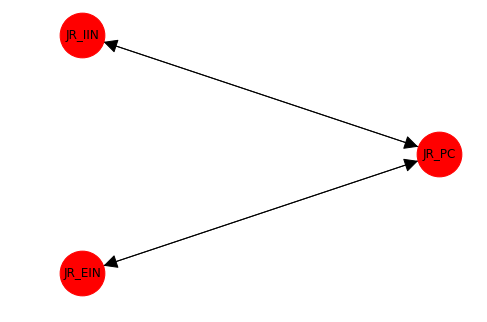

In [92]:
import matplotlib.pyplot as plt
import networkx as nx
pos=nx.spring_layout(circuit)
nx.draw_shell(circuit, with_labels=True, node_size=2000, arrowsize=30)